## Program to read Datawell daily .csv file of WSEs

Selected D:\brisbane_4183\2023\07\brisbane_4183{disp}2023-07-22.csv
Reading data from file to dataframe
Preparing plots


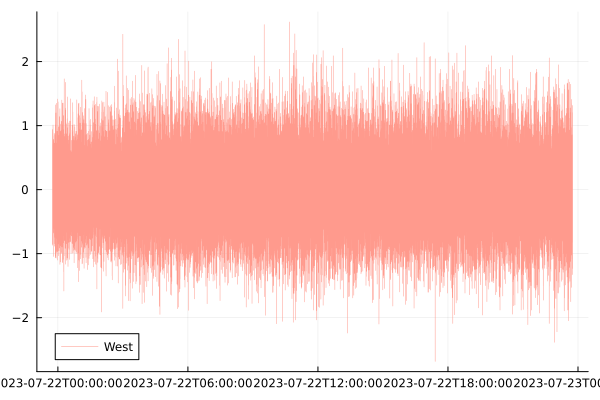

In [1]:
using CSV
using Dates, DataFrames, DSP
using LaTeXStrings
using NativeFileDialog
using Plots, Printf
using Statistics
using Tk


function plot_spectra(record_df)
################################################    
    Sample_frequency = 2.56

    function calc_freq_pden(wse)
        ps_w = DSP.Periodograms.welch_pgram(float(wse), 512, 256; onesided=true, nfft=512, fs=Sample_frequency, window=hanning);
        freqs = freq(ps_w);
        pden = power(ps_w);

        return(freqs, pden)

        end

    heave = float.(record_df.Heave)
    north = float.(record_df.North)
    west = float.(record_df.West)

    east = -west

    heave_freq, heave_pden = calc_freq_pden(heave);
    north_freq, north_pden = calc_freq_pden(north);
    west_freq, west_pden = calc_freq_pden(west);

    title_string = Dates.format(first(record_df.Date), "dd/mm/yyyy HH:MM")

    max_y = max(heave_pden[argmax(heave_pden)], north_pden[argmax(north_pden)], west_pden[argmax(west_pden)])

    # Plot the spectra for heave, North, and West
    spectra = plot(heave_freq,heave_pden, c=:red, lw=3, alpha=.5, fillrange = 0, fillalpha = 0.015, fillcolor = :red, label="Heave", xlim=(0,1.0), ylim=(0,max_y*1.05),
        xticks = (0.0:0.1:1.0, string.(0.0:0.1:1.0)), xtickfontsize=7, xlabel="Frequency (Hertz)",
        ytickfontsize=8, ylabel="Spectral Density (m"*L"^2"*"/Hz.)")
    spectra = plot!(north_freq,north_pden, c=:green, lw=3, alpha=.5, fillrange = 0, fillalpha = 0.015, fillcolor = :green, label="North")
    spectra = plot!(west_freq,west_pden, c=:blue, lw=3, alpha=.5, fillrange = 0, fillalpha = 0.015, fillcolor = :red,  label="West")
    spectra = vline!([0.05; 0.05], lw=2, ls =:dash, c=:red, label="")

    # Plot scatter of East-West and North-South buoy movement
    p1 = plot(west,north, zcolor=heave, m=(1, 3, :RdYlGn_11, Plots.stroke(0)), leg=false, cbar=false, c="lightgrey", label="",
        aspect_ratio=:equal,
##        xlim=(minimum(west)*1.1,maximum(west)*1.1), ylim=(minimum(north)*1.1,maximum(north)*1.1), 
            w=0.5, title="West-North", titlefontsize=10, xlabel="East-West displacement (m)", ylabel="North-South displacement (m)")
    spectral_plot = plot(spectra, p1, layout = Plots.grid(1, 2, widths=(5/8,3/8)), size = (1400, 600), framestyle = :box,
        fg_legend=:transparent, bg_legend=:transparent, legend=:topright, foreground_color_grid="lightgrey", 
        xtickfontsize=8, ytickfontsize=8, xguidefontsize=10, yguidefontsize=10,
        grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, show=true,
        title=title_string, titlefontsize=12, margin = 10Plots.mm) 

    display(spectral_plot)

    return()

    end    # plot_spectra()


function plot_hnw(record_df, first_date, last_date)
######################################## 

    function spike_value(wse)
    #####################################    
        median_value = median(wse)
        std_value = std(wse)
        
        return(median_value + 3*std_value)
        
        end    # spike_value()


    # get WSEs for desired 30-minute record
    heave = record_df.Heave
    north = record_df.North
    west = record_df.West

    spike = spike_value(heave)
    heave_spikes = findall(i->(i>=spike), abs.(heave));

    spike = spike_value(north)
    north_spikes = findall(i->(i>=spike), abs.(north));

    spike = spike_value(west)
    west_spikes = findall(i->(i>=spike), abs.(west));

    times = record_df.Date

    # create plots of heave, north, and west
    title_string = Dates.format(first(record_df.Date), "dd/mm/yyyy HH:MM")
    p1_hnw = scatter(times[heave_spikes], heave[heave_spikes], label="", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p1_hnw = plot!(times,heave, label="", c="#4a536b", lw=0.5, title=title_string, titlefontsize=12) ##last(split(infil,"\\")))

    # get plotting limits
    x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
    x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

    p2_hnw = scatter(times[north_spikes], north[north_spikes], label="", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p2_hnw = plot!(times,north, label="", c="#aed6dc", lw=0.5)
    
    p3_hnw = scatter(times[west_spikes], west[west_spikes], label="", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p3_hnw = plot!(times,west, label="", c="#ff9a8d", lw=0.5)

    hline!(p1_hnw, [0], lw=1, label="")
    hline!(p2_hnw, [0], lw=1, label="")
    hline!(p3_hnw, [0], lw=1, label="")

    # get plotting limits
    x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
    x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

    # display plots to screen
    # display plots to screen
    tm_tick = range(first_date,last_date,step=Minute(2))
    ticks = Dates.format.(tm_tick,"MM:SS")

    plot_wse = Plots.plot(p1_hnw, p2_hnw, p3_hnw, xtick=(tm_tick,ticks), layout = (3, 1), size = (1400, 600),
##        xlim=(first(times),last(times)),  xticks = first(times):Minute(5):last(times),xtickfontsize=7,ytickfontsize=8,
        xlim=(first_date,last_date),  xticks = first(times):Minute(5):last(times),xtickfontsize=7,ytickfontsize=8,
        framestyle = :box,fg_legend=:transparent, legend=:bottomleft,
        margin = 1Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)            

    display(plot_wse)

    # create a plot file to be saved as a .PNG
##    plt_file = first(infil, length(infil)-4)*"_plot_hnw_"*Dates.format(start_date, "yyyy_mm_dd_HHMM")*".png"

    # Save plot to file
##    savefig(plt_file)
##    println("Plot file saved as ",plt_file)
       
    end    # plot_hnw()


###############################################
################################################
################################################
##           START OF MAIN PROGRAM
################################################
################################################
################################################

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

# Select a CSV file
infil = pick_file("C:\\QGHL\\Wave_data\\", filterlist="CSV,csv");
println("Selected ",infil)

if uppercase(split(infil, ".")[end]) == "CSV"

    # read .csv file to df
    println("Reading data from file to dataframe")
    flush(stdout)
    df = DataFrame(CSV.File(infil,header=0, delim="\t"));
    
    # name df headers
    rename!(df,[:Date,:Status, :Heave, :North, :West]);

    # convert Epoch seconds to UTC datetime
    df.Date = unix2datetime.(df.Date);
    
else

    println("Not able to read this file type at present")
    flush(stdout)
    exit()

end

# get date of .csv file
file_date = DateTime(last(split(first(infil, length(infil)-4),"}")))
first_date = file_date; last_date = first_date + Day.(1)

println("Preparing plots")
flush(stdout)
title_string = Dates.format.(file_date,"dd/mm/yyyy")
##title_string = Dates.format(first(df.Date), "dd/mm/yyyy HH:MM") * " to " * Dates.format(last(df.Date), "dd/mm/yyyy HH:MM")
p1_hnw = Plots.plot(df.Date, df.Heave, label="Heave", c="#4a536b", lw=0.5, alpha=0.5, title=title_string, titlefontsize=12) ##last(split(infil,"\\")))
p2_hnw = Plots.plot(df.Date, df.North, label="North", c="#aed6dc", lw=0.5)
p3_hnw = Plots.plot(df.Date, df.West, label="West", c="#ff9a8d", lw=0.5)

In [ ]:
# display plots to screen
tm_tick = range(first_date,last_date,step=Hour(1))
ticks = Dates.format.(tm_tick,"HH:MM")
plot_wse = plot(p1_hnw, p2_hnw, p3_hnw, xtick=(tm_tick,ticks), layout = (3, 1), size = (1400, 500),
    xlim=(first(df.Date),last(df.Date)), xtickfontsize=7,ytickfontsize=8,
    framestyle = :box,fg_legend=:transparent, legend=:topleft,
    margin = 1Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

display(plot_wse)

################################################
################################################
##           END OF MAIN PROGRAM
################################################
################################################

## Get 30-minute time series and spectral plots

In [ ]:
# Create an array of datetimes at 30-minute spacing
dd = file_date:Dates.Minute(30):file_date + Day(1)

# Convert datetime array to string array
dates = Dates.format.(dd, "yyyy-mm-dd HH:MM")

w = Toplevel("Select Date", 235, 600)
tcl("pack", "propagate", w, false)
f = Frame(w)
pack(f, expand=true, fill="both")

f1 = Frame(f)
lb = Treeview(f1, dates)
scrollbars_add(f1, lb)
pack(f1,  expand=true, fill="both")

tcl("ttk::style", "configure", "TButton", foreground="blue", font="arial 16 bold")
b = Button(f, "Ok")
pack(b)

bind(b, "command") do path
    
    date_choice = get_value(lb);
    
    first_date = DateTime(date_choice[1], dateformat"y-m-d H:M:S")
    last_date = first_date + Minute.(30)

    println(first_date,' ',last_date)
    flush(stdout)
    record_df = df[first_date .<= df.Date .< last_date, :]
    
    plot_hnw(record_df, first_date, last_date)
    plot_spectra(record_df)

end

In [ ]:
last(df)

In [ ]:
function show_waves(heave)
################################################

    for i in 2:length(heave)-1
        if (heave[i]*heave[i+1] < 0 && heave[i+1] > 0) || (heave[i] == 0 && heave[i-1] < 0 && heave[i+1] > 0)
            push!(zero_up,i)
        end
    end

    ##med = median(heave)
    ##stdev = std(heave)
    ##stdev_3 = med + stdev*3

    wse_point = collect(1:1:length(heave))
    wse_1 = plot(wse_point, heave[wse_point], c=:blue, alpha=.5, label = "WSE's", fillrange = 0, fillalpha = 0.0075, fillcolor = :blue)
    wse_1 = scatter!(wse_point, heave[wse_point], c=:white, ms=3, 
        markerstrokecolor=:blue, alpha=0.5, markerstrokewidth=0.5, label="WSE points")
    wse_1 = scatter!(zero_up, heave[zero_up], ms=4, c=:lightgreen, 
        markerstrokecolor=:green, alpha=0.5, series_annotations = text.(zero_up, :bottom, :red, :size, 10), 
        annotationhalign = :hcenter, label="Zero up-cross points")

    # heave Threshold set at 10mm. Refer to Section 9 Wave statistics pp. 9-10 in Datawell Library Manual
    threshold = 0.05

    wse_1 = hline!([threshold; threshold], lw=0.2, ls =:dot, c=:red, label="Threshold ("*L"\pm"*string(threshold)*")\n")
    wse_1 = hline!([-threshold; -threshold], lw=0.2, ls =:dot, c=:red, label="")

    ##wse_1 = hline!([stdev_3; stdev_3], lw=0.2, ls =:dot, c=:green, label="3 sigma")
    ##wse_1 = hline!([-stdev_3; -stdev_3], lw=0.2, ls =:dot,  c=:green, label="")

    wse_plot = plot(wse_1, size = (1500, 500),xlim=(1,500), ylim=(-1.5,1.5), framestyle = :box, 
        fg_legend=:transparent, bg_legend=:transparent, legend=:topright,
        margin = 1Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, show=true)

    display(wse_plot)
    
    return()
    
    end    # show_waves()


function show_zero_x(heave, start_date)
################################################

    zero_up = []; valid_zero_up = []

    for i in 2:length(heave)-1
        if (heave[i]*heave[i+1] < 0 && heave[i+1] > 0) || (heave[i] == 0 && heave[i-1] < 0 && heave[i+1] > 0)
            push!(zero_up,i)
        end
    end
    
    # heave Threshold set at 10mm. Refer to Section 9 Wave statistics pp. 9-10 in Datawell Library Manual
    threshold = 0.05

##    valid_zero_up = []; 
    crest_points = []; trough_points = []
    i = 1; j = 2

    while j < length(zero_up)-1

        crest = maximum(heave[zero_up[i]:zero_up[j]])
        crest_point = zero_up[i] + argmax(heave[zero_up[i]:zero_up[j]]) - 1
        trough = minimum(heave[crest_point:zero_up[j]])

        # Check that crest higher than threshold AND trough less than threshold - Possible Valid Wave!!
        if (crest > threshold) & (trough < -threshold)
            crest_point = zero_up[i] + argmax(heave[zero_up[i]:zero_up[j]]) - 1
            trough_point = crest_point + argmin(heave[crest_point:zero_up[j]]) - 1

            push!(crest_points,crest_point)
            push!(trough_points,trough_point)

            next_crest = maximum(heave[zero_up[j]:zero_up[j+1]])

            # Check that NEXT crest also exceeds threshold (if so then Valid Wave)
            if (next_crest > threshold)
    ##            println("Crest found at ",crest_point," Trough at ",trough_point)
                push!(valid_zero_up,(zero_up[i],zero_up[j]));
                i = j
            end

        end

        j = j+1

    end

    # Process last recorded wave
    #i = j
    #j = j+1

    crest = maximum(heave[zero_up[i]:zero_up[j]])
    trough = minimum(heave[zero_up[i]:zero_up[j]])

    if (crest > threshold) & (trough < -threshold)

        crest_point = zero_up[i] + argmax(heave[zero_up[i]:zero_up[j]]) - 1
        trough_point = crest_point + argmin(heave[crest_point:zero_up[j]]) - 1
        push!(valid_zero_up,(zero_up[i],zero_up[j]));

    end

    heights = []

    for i in 1:length(valid_zero_up)

        crest = maximum(heave[valid_zero_up[i][1]:valid_zero_up[i][2]]);
        trough = minimum(heave[valid_zero_up[i][1]:valid_zero_up[i][2]]);
        push!(heights,crest - trough)
    ##    @printf("Wave %d = %2.3f\n",i,crest - trough)

    end 

    # Get time-domain height parameters
    sorted_heights = sort(heights, rev=true) # sort heights in reverse order heighestwave to loheave wave
    hmax = maximum(sorted_heights)
    hs = mean(sorted_heights[1:Int(ceil(length(sorted_heights)/3))])
    h10 = mean(sorted_heights[1:Int(ceil(length(sorted_heights) / 10))])
    hmean = mean(sorted_heights)

    @printf("%s; Waves = %3d; Hmean = %4.2fm; Hs = %4.2fm; H10 = %4.2fm; Hmax = %4.2fm\n",Dates.format(start_date, "yyyy-mm-dd HH:MM"),length(heights), hmean, hs, h10, hmax)

    ## Locate the zero-crossing points

    x_point = []
    for i in 1:length(valid_zero_up)
        push!(x_point,valid_zero_up[i][1] + abs(heave[valid_zero_up[i][1]]) / (heave[valid_zero_up[i][1]+1] - heave[valid_zero_up[i][1]]))
    end

    # Process final zero-crossing point
    i = length(valid_zero_up)
    push!(x_point,valid_zero_up[i][2] + abs(heave[valid_zero_up[i][2]]) / (heave[valid_zero_up[i][2]+1] - heave[valid_zero_up[i][2]]))

    # Do plots
    wse_point = collect(1:1:length(heave))
    wse_1 = plot(wse_point, heave[wse_point], c=:blue, alpha=0.5, label = "WSE's", fillrange = 0, fillalpha = 0.175, fillcolor = :blue)
    wse_1 = scatter!(wse_point, heave[wse_point], c=:white, ms=3, 
        markerstrokecolor=:blue, alpha=0.5, markerstrokewidth=0.5,label="WSE points")
    wse_1 = scatter!(zero_up, heave[zero_up], ms=3, c=:lightgreen, 
        markerstrokecolor=:lightgreen, series_annotations = text.(zero_up, :bottom, :red, :size, 10), 
        annotationhalign = :hcenter, label="Zero up-cross points\n")
    wse_1 = scatter!(x_point, zeros(length(x_point)), c=:yellow, ms=5, 
        markerstrokecolor=:yellow, markershape=:diamond, label="Zero-crossing points")
    # heave Threshold set at 10mm. Refer to Section 9 Wave statistics pp. 9-10 in Datawell Library Manual
    threshold = 0.05 

    wse_1 = hline!([threshold; threshold], lw=0.2, ls =:dot, c=:red, label="Threshold\n")
    wse_1 = hline!([-threshold; -threshold], lw=0.2, ls =:dot, c=:red, label="")

    wse_plot = plot(wse_1, size = (1500, 500), xlim=(1,500), ylim=(-1.5,1.5), framestyle = :box, 
        fg_legend=:transparent, bg_legend=:transparent, legend=:topright,
        margin = 1Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, show=true)

    display(wse_plot)
    
    return()

    end    # show zero_x()


w = Toplevel("Select Date", 235, 600)
tcl("pack", "propagate", w, false)
f = Frame(w)
pack(f, expand=true, fill="both")

f1 = Frame(f)
lb = Treeview(f1, dates)
scrollbars_add(f1, lb)
pack(f1,  expand=true, fill="both")

tcl("ttk::style", "configure", "TButton", foreground="blue", font="arial 16 bold")
b = Button(f, "Ok")
pack(b)

bind(b, "command") do path
    
    date_choice = get_value(lb);
    
    global first_date = DateTime(date_choice[1], dateformat"y-m-d H:M:S")
    global last_date = first_date + Minute.(30)

##    println(date_choice,' ',first_date,' ',last_date)
##    println(first_date,' ',last_date)
##    flush(stdout)
    global record_df = df[first_date .<= df.Date .< last_date, :]
    
    global zero_up = []; global valid_zero_up = []
    global heave = record_df.Heave
    
#    show_waves(record_df.Heave)
    show_zero_x(record_df.Heave, first(record_df.Date))
    
end

In [ ]:
using CSV
using Dates, DataFrames
using NativeFileDialog
using Plots, Printf

################################################
################################################
################################################
##           START OF MAIN PROGRAM
################################################
################################################
################################################

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")
# Pick directory containing .BVA files
datawell_directory = pick_folder("C:\\QGHL\\Wave_data\\")

# build list of all Datawell files in selected directory
datawell_files = filter(x->occursin("{disp}",x), readdir(datawell_directory));
datawell_files = datawell_files[findall(x->endswith(uppercase(x), ".CSV"), datawell_files)]

# Check whether any Datawell files exist in selected directory. If not, EXIT!
if length(datawell_files) == 0
    println("No Datawell files found in "*datawell_directory)
    exit;
end

# create a df to hold the wse's
wse_df = DataFrame(Date = [], Status = [], Heave = [], North = [], West = [])

for infil in datawell_files
    println("Reading " * infil)
    
    df = DataFrame(CSV.File(datawell_directory*"\\"*infil,header=0, delim="\t"))
    rename!(df,[:Date, :Status, :Heave, :North, :West]);
    wse_df = vcat([wse_df,df]...)
end

# convert Epoch time to UTC
wse_df.Date = unix2datetime.(wse_df.Date);

## Plot selected month - WARNING - This takes forever

In [ ]:
# get date of .csv file
first_date = first(wse_df.Date)
last_date = last(wse_df.Date)

println("Preparing plots")
flush(stdout)
title_string = Dates.format.(first_date,"dd/mm/yyyy") * " - " * Dates.format.(last_date,"dd/mm/yyyy")
##title_string = Dates.format(first(df.Date), "dd/mm/yyyy HH:MM") * " to " * Dates.format(last(df.Date), "dd/mm/yyyy HH:MM")
p1_hnw = plot(wse_df.Date, wse_df.Heave, label="Heave", c="#4a536b", lw=0.5, alpha=0.5, title=title_string, titlefontsize=12) ##last(split(infil,"\\")))
p2_hnw = plot(wse_df.Date, wse_df.North, label="North", c="#aed6dc", lw=0.5)
p3_hnw = plot(wse_df.Date, wse_df.West, label="West", c="#ff9a8d", lw=0.5)

# display plots to screen
tm_tick = range(first_date,last_date,step=Hour(1))
ticks = Dates.format.(tm_tick,"HH:MM")
plot_wse = plot(p1_hnw, p2_hnw, p3_hnw, xtick=(tm_tick,ticks), layout = (3, 1), size = (1400, 500),
    xlim=(first_date,last_date), ylim=(0,Inf), xtickfontsize=7,ytickfontsize=8,
    framestyle = :box,fg_legend=:transparent, legend=:topleft,
    margin = 1Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

display(plot_wse)

In [ ]:
wse_point = collect(1:1:length(heave))

plot([record_df.Date[1] + Microsecond(Int(x/2.56*1000000)) - Microsecond(Int(1/2.56*1000000)) for x in wse_point], heave, size = (1500, 500), label="Heave", framestyle = :box, 
        fg_legend=:transparent, bg_legend=:transparent, legend=:topright,
        margin = 1Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, show=true)

In [ ]:
record_df.Date[1] 

## Read F26 .csv file

In [ ]:
using CSV
using Dates, DataFrames, DSP
using LaTeXStrings
using NativeFileDialog
using Plots, Printf
using Statistics
using Tk

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

# Select a CSV file
infil = pick_file("C:\\QGHL\\Wave_data\\", filterlist="CSV,csv,{0xF26}");
println("Selected ",infil)

if uppercase(split(infil, ".")[end]) == "CSV"

    # read .csv file to df
    println("Reading data from file to dataframe")
    flush(stdout)
    df = DataFrame(CSV.File(infil,header=0, delim="\t"));
    
# name df headers
    rename!(df,[:Date,:Status, :Hmax, :THmax, :Tmax, :HTmax, :Havg, :Tavg, :HsRMS, :Nw, :Nc, :epsilon, :Coverage]);

    # convert Epoch seconds to UTC datetime
    df.Date = unix2datetime.(df.Date);
    
else

    println("Not able to read this file type at present")
    flush(stdout)
    exit()

end    

In [ ]:
plot(df.Date, df.Tmax, size = (1800,600))

In [ ]:
using CSV
using Dates, DataFrames, Distributions, DSP
using Gtk
using LaTeXStrings
using NativeFileDialog
using Plots, Printf

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

# select directory
csv_directory = pick_folder()

# build list of all csv files in selected directory
csv_files = filter(x->occursin(".csv",x), readdir(csv_directory));

# select the 0xF26 file
try
    f26_file_name = csv_files[findfirst(contains("{0xF26}"),csv_files[findall(x->endswith(uppercase(x), ".CSV"), csv_files)])];

    f26_file = csv_directory * "\\"* f26_file_name 

    # create a df to hold the F26 data
    f26_df = DataFrame(CSV.File(f26_file,header=0, delim="\t"));
    rename!(f26_df,[:Date,:Status, :Hmax, :THmax, :Tmax, :HTmax, :Havg, :Tavg, :HsRMS, :Nw, :Nc, :epsilon, :Coverage]);

    # convert Epoch seconds to UTC
    f26_df.Date = unix2datetime.(f26_df.Date);
    f26_df.Date = f26_df.Date
    start_date = first(f26_df.Date)
    end_date =last(f26_df.Date)
    start_date_string = Dates.format(start_date, "dd/mm/yyyy HH:MM")
    end_date_string = Dates.format(end_date, "dd/mm/yyyy HH:MM")

    suspects = findall(f26_df.Tmax .> 18)

    # plot height parameters Hmax and HTmax
    f26_p1 = plot(f26_df.Date, f26_df.Hmax, lc=:red, lw=:0.5, label="Hmax", title=start_date_string * " to " * end_date_string, ylabel="Height (m)");
    f26_p1 = plot!(f26_df.Date, f26_df.HTmax, lc=:blue, lw=:0.5, label="Htmax") 
    if length(suspects) > 0
        for i in suspects
            @printf("Suspect Tmax (%2.1f) at %s\n",f26_df[i,:].Tmax, Dates.format(f26_df[i,:].Date, "dd-u HH:MM"))
            f26_p1 = vline!([f26_df[i,:].Date], lc=:red, lw=:0.75, ls=:dash, label="")
        end
    else
        println("No suspects detected!\n")
    end

    # plot period parameters THmax and Tmax
    f26_p2 = plot(f26_df.Date, f26_df.THmax, lc=:red, lw=:0.5, label="THmax", ylabel="Period (s)");    
    f26_p2 = plot!(f26_df.Date, f26_df.Tmax, lc=:blue, lw=:0.5, label="Tmax")
    if length(suspects) > 0
        for i in suspects
            f26_p2 = vline!([f26_df.Date[i]], lc=:red, lw=:0.75, ls=:dash, label="")
        end
    end

    plot_title_string = f26_file_name

    # create the date/time ticks for x-axis
    tm_tick = range(DateTime(Date(start_date)), DateTime(Date(end_date) + Day(1)), step=Day(1))
    ticks = Dates.format.(tm_tick,"dd")

    show_plot = plot(f26_p1, f26_p2, layout=(2,1), size=(1800,700), 
    #    xlim=(start_date,end_date), xticks=(tm_tick,ticks), xtickfontsize=7, ytickfontsize=12,
        xlim=(DateTime(Date(start_date)),DateTime(Date(end_date) + Day(1))), xticks=(tm_tick,ticks), xminorticks=4, xtickfontsize=7, ytickfontsize=12,
        framestyle = :box, plot_title=plot_title_string, plot_titlefontsize=12, titlefontsize=10, 
        fg_legend=:transparent, bg_legend=:transparent, legend=:topright,
        leftmargin = 10Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, show=true)

    display(show_plot)
    
catch
    
    println("No 0xF26 file found in this directory!")
    
end

## Do polar plots of all records in selected day

In [ ]:
using CSV, CairoMakie
using Dates, DataFrames, Distributions, DSP
#using Gtk
using LaTeXStrings
using NativeFileDialog
using Plots, Printf, PyPlot
using Statistics #, StatsPlots
#using Tk


function do_subplot(x, y, z)
############################    
    ax = subplot(x, y, z, polar="true") 
    ax.grid(:true, fontsize=:10)
    ax.set_rlabel_position(-90)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    PyPlot.title(string(z))

end    # do_subplot()
    

function smooth_spectra(Pden_in, sample_frequency)
##################################################
# smooth the spectra into bands centered on 0.05Hz spacing (i.e. 0:0.005:0.64)
    nyquist = sample_frequency/2

    freq_in = range(0, stop=nyquist, length=length(Pden_in))

    freq_out = [0.0]
    Pden_smoothed = [mean(Pden_in[1:8])]

    i = 9
    while i <= length(Pden_in)

        push!(freq_out,freq_in[i+8])

        if i < length(Pden_in)-16

            push!(Pden_smoothed, mean(Pden_in[i:i+16]))

        end

        i+=16

    end

    push!(Pden_smoothed, mean(Pden_in[end-8:end]))
            
    return (freq_out, Pden_smoothed)
        
end


function get_Fourier_coefficients(heave, north, west)
#####################################################    
    # Get the cross periodograms
    cps_heave_heave = mt_cross_power_spectra([heave heave]', fs=sample_frequency);
    cps_north_north = mt_cross_power_spectra([north north]', fs=sample_frequency);
    cps_west_west = mt_cross_power_spectra([west west]', fs=sample_frequency);

    cps_north_heave = mt_cross_power_spectra([north heave]', fs=sample_frequency);
    cps_west_heave = mt_cross_power_spectra([west heave]', fs=sample_frequency);
    cps_north_west = mt_cross_power_spectra([north west]', fs=sample_frequency);

##    fhh = cps_heave_heave.freq
    fhh, Chh = smooth_spectra(real.(cps_heave_heave.power[1,1,:]), sample_frequency)

    #fnn = cps_north_north.freq
    fhh, Cnn = smooth_spectra(real.(cps_north_north.power[1,1,:]), sample_frequency)

    #fww = cps_west_west.freq
    fhh, Cww = smooth_spectra(real.(cps_west_west.power[1,1,:]), sample_frequency)

    #fnw = cps_north_west.freq
    fhh, Cnw = smooth_spectra(real.(cps_north_west.power[1,2,:]), sample_frequency)

    #fnh = cps_north_heave.freq
    fhh, Qnh = smooth_spectra(imag.(cps_north_heave.power[1,2,:]), sample_frequency)

    #fwh = cps_west_heave.freq
    fhh, Qwh = smooth_spectra(imag.(cps_west_heave.power[1,2,:]), sample_frequency)

    a1 = Qnh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5
    b1 = -Qwh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5

    a2 = (Cnn .- Cww) ./ (Cnn .+ Cww)
    b2 = -2 .* Cnw ./ (Cnn .+ Cww)
    
    return(fhh, Chh, a1, b1, a2, b2)
    
end    # get_Fourier_coefficients()


function get_displacements(arry)
#####################################
    
    displacements = []

    if length(arry[1]) == 3
    
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^2 + parse(Int, SubString.(i, 2, 2), base=16)*16^1 + parse(Int, SubString.(i, 3, 3), base=16)*16^0)
        end
        
    else
        
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
        end
        
    end

    displacements[findall(>=(2048), displacements)] = 2048 .- displacements[findall(>=(2048), displacements)];
    
    return(displacements./100)
    
end     # get_displacements()


function get_HNW(infil)
#####################################
        
    global df = DataFrame(CSV.File(infil,header=0, delim=",", types=String));

    # Calculate sequence numbers
    arry = SubString.(df.Column1, 3, 4)

    global sequence = []

    for i in arry
        append!(sequence,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
    end

    arry = SubString.(df.Column3, 1, 3);
    heave = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2)
    north = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1)
    west = get_displacements(arry);

    return(heave, north, west)

    end    # get_HNW()


function plot_polar(fig, displacement_df, row, col, total, spec_max)
####################################################################
    
    Chh = displacement_df.Chh[total]
    a1 = displacement_df.a1[total]
    b1 = displacement_df.b1[total] 
    a2 = displacement_df.a2[total] 
    b2 = displacement_df.b2[total]
    time_string  = displacement_df.Time_string[total]

    aa = length(Chh)

    r = 1:4:aa
    ρ = r ./ (aa/nyquist) 

    θ = 0:pi/180:2pi

    mat =  []

    for j in r

        for i in θ

            push!(mat,Chh[j] * (a1[j]*cos(i) + b1[j]*sin(i) + a2[j]*cos(2i) + b2[j]*sin(2i)))

        end

    end

    mat[mat .< 0] .= 0

    mat = reshape(mat, length(θ), length(r))
    time_string = displacement_df.Time_string[total]

    ax = CairoMakie.PolarAxis(fig[row, col],
    thetaticklabelsize = 15,  
    rlimits=(0,0.4), rticklabelsize=15, rticks=0:0.2:0.4, rgridwidth=0.5, rtickangle=180, rminorgridvisible=true, rminorgridstyle=:dot,
    theta_0=-pi/2, thetagridwidth=0.5, thetaminorgridvisible=true, thetaminorgridstyle=:dot, thetaminorticks=IntervalsBetween(3), 
    direction=-1, width=330, height=310, title=time_string, titlesize=18,
    )

    CairoMakie.contourf!(ax, θ, ρ, Float64.(mat), colormap=Reverse(:ocean), levels = 0.02:0.05:1, mode = :relative,)
    CairoMakie.contour!(ax, θ, ρ, Float64.(mat), cmap=Reverse(:ocean))
    
    return(fig)
    
    end    # plot_polar()


#######################################################################################
#######################################################################################
#######################################################################################    

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")
const sample_frequency = 2.56

nyquist = sample_frequency/2

# build df containing displacements and Fourier coefficient for selected day
displacement_df = DataFrame(Time_string = [], Heave = [], North = [], West = [], fhh = [], Chh = [], a1 = [], b1 = [], a2 = [], b2 = [])

println("Reading 30-minute records:")
flush(stdout)

fl_num = 1
for fl in hxv_files
    
    infil = hxv_directory * "\\" * fl
    date_string = split(hxv_directory,"\\")[end]
    global time_string = replace(split(infil,date_string)[end][2:6], 'h' => ':')

    if (mod(fl_num,10) == 0)
        print(string(fl_num))
    else
        print(".")
    end
        
    global heave, north, west = df.Heave, df.North, df.West
    fhh, Chh, a1, b1, a2, b2 = get_Fourier_coefficients(heave, north, west)
    
    push!(displacement_df, (time_string, heave, north, west, fhh, Chh, a1, b1, a2, b2))
    fl_num += 1
end
    
#######################################################################################
#######################################################################################
#######################################################################################    

fig = CairoMakie.Figure(size=(1200, 3000))

date_string = split(hxv_directory,"\\")[end]
println("\nSpectral peak for "*date_string*" occurred at "*displacement_df.Time_string[argmax(maximum.(displacement_df.Chh))])
    
supertitle = fig[0, :] = Label(fig, date_string,
fontsize = 24, color = (:black, 0.25))

# get the highest energy value for the day
spec_max = maximum(maximum.(displacement_df.Chh))

total=0
println("\nPreparing plots now:")
for row = 1:8

    for col in 1:6

        total+=1        
        
        if (mod(total,10) == 0)
            print(string(total))
        else
            print(".")
        end
        
        try
            
            fig = plot_polar(fig, displacement_df, row, col, total, spec_max)
        
        catch
            
            println("Alert: Not all 48 records available for this day")
            break
            
        end    
    
    end
    
end

CairoMakie.Colorbar(fig[9, 1], limits=(0, round(spec_max, digits=1, RoundUp)), label="Spectral Density (m²/Hz.)", labelsize=:20, 
        width=500, height=30, vertical=false, flipaxis=false, colormap=Reverse(:ocean))

resize_to_layout!(fig)

fig
#==
try
    site_string = split(hxv_directory, "\\")[end-2]
    CairoMakie.save(site_string*"_"*date_string*"_polar_plots.png", fig, px_per_unit = 1)
catch
    "Alert: Plot not saved!"
end
    
==#

In [ ]:
day.(df.Date) == mode(day.(df.Date))

In [ ]:
using StatsBase

# select rows for the day of interest only
day_df = df[findall(day.(df.Date) .== mode(day.(df.Date))),:]

In [ ]:
using TimeSeries, Dates

# Create a TimeArray from the timestamp column
ta = convert(TimeArray, day_df.Date)

# Define the frequency of the TimeArray
freq = Dates.Minute(30)

# Group the TimeArray into 10-minute blocks
grouped_ta = group(ta, freq)

# Convert the grouped TimeArray back to a DataFrame
grouped_df = DataFrame(grouped_ta)

In [ ]:
heave, north, west = df.Heave, df.North, df.West

In [ ]:
function do_subplot(x, y, z)
############################    
    ax = subplot(x, y, z, polar="true") 
    ax.grid(:true, fontsize=:10)
    ax.set_rlabel_position(-90)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    PyPlot.title(string(z))

end    # do_subplot()
    

function smooth_spectra(Pden_in, sample_frequency)
##################################################
# smooth the spectra into bands centered on 0.05Hz spacing (i.e. 0:0.005:0.64)
    nyquist = sample_frequency/2

    freq_in = range(0, stop=nyquist, length=length(Pden_in))

    freq_out = [0.0]
    Pden_smoothed = [mean(Pden_in[1:8])]

    i = 9
    while i <= length(Pden_in)

        push!(freq_out,freq_in[i+8])

        if i < length(Pden_in)-16

            push!(Pden_smoothed, mean(Pden_in[i:i+16]))

        end

        i+=16

    end

    push!(Pden_smoothed, mean(Pden_in[end-8:end]))
            
    return (freq_out, Pden_smoothed)
        
end    # smooth_spectra()


function get_Fourier_coefficients(heave, north, west)
#####################################################    
    # Get the cross periodograms
    cps_heave_heave = mt_cross_power_spectra([heave heave]', fs=sample_frequency);
    cps_north_north = mt_cross_power_spectra([north north]', fs=sample_frequency);
    cps_west_west = mt_cross_power_spectra([west west]', fs=sample_frequency);

    cps_north_heave = mt_cross_power_spectra([north heave]', fs=sample_frequency);
    cps_west_heave = mt_cross_power_spectra([west heave]', fs=sample_frequency);
    cps_north_west = mt_cross_power_spectra([north west]', fs=sample_frequency);

##    fhh = cps_heave_heave.freq
    fhh, Chh = smooth_spectra(real.(cps_heave_heave.power[1,1,:]), sample_frequency)

    #fnn = cps_north_north.freq
    fhh, Cnn = smooth_spectra(real.(cps_north_north.power[1,1,:]), sample_frequency)

    #fww = cps_west_west.freq
    fhh, Cww = smooth_spectra(real.(cps_west_west.power[1,1,:]), sample_frequency)

    #fnw = cps_north_west.freq
    fhh, Cnw = smooth_spectra(real.(cps_north_west.power[1,2,:]), sample_frequency)

    #fnh = cps_north_heave.freq
    fhh, Qnh = smooth_spectra(imag.(cps_north_heave.power[1,2,:]), sample_frequency)

    #fwh = cps_west_heave.freq
    fhh, Qwh = smooth_spectra(imag.(cps_west_heave.power[1,2,:]), sample_frequency)

    a1 = Qnh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5
    b1 = -Qwh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5

    a2 = (Cnn .- Cww) ./ (Cnn .+ Cww)
    b2 = -2 .* Cnw ./ (Cnn .+ Cww)
    
    return(fhh, Chh, a1, b1, a2, b2)
    
end    # get_Fourier_coefficients()


function get_displacements(arry)
#####################################
    
    displacements = []

    if length(arry[1]) == 3
    
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^2 + parse(Int, SubString.(i, 2, 2), base=16)*16^1 + parse(Int, SubString.(i, 3, 3), base=16)*16^0)
        end
        
    else
        
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
        end
        
    end

    displacements[findall(>=(2048), displacements)] = 2048 .- displacements[findall(>=(2048), displacements)];
    
    return(displacements./100)
    
end     # get_displacements()


function get_HNW(infil)
#####################################
        
    global df = DataFrame(CSV.File(infil,header=0, delim=",", types=String));

    # Calculate sequence numbers
    arry = SubString.(df.Column1, 3, 4)

    global sequence = []

    for i in arry
        append!(sequence,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
    end

    arry = SubString.(df.Column3, 1, 3);
    heave = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2)
    north = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1)
    west = get_displacements(arry);

    return(heave, north, west)

    end    # get_HNW()


function get_spec_dir(displacement_df, total)

    Chh = displacement_df.Chh[total]
    a1 = displacement_df.a1[total]
    b1 = displacement_df.b1[total] 
    a2 = displacement_df.a2[total] 
    b2 = displacement_df.b2[total]
    time_string = displacement_df.Time_string[total]

    aa = length(Chh) # Number of spectral points

    r = 1:3:aa
    ρ = r ./ (aa/nyquist) 

    θ = 0:pi/180:2pi

#    mat =  []

    mat = [Chh[j] * (a1[j]*cos(i) + b1[j]*sin(i) + a2[j]*cos(2i) + b2[j]*sin(2i)) for i in θ, j in r]

    mat[mat .< 0] .= 0
    
    return(θ, ρ, mat, time_string)
    
end    # get_spec_dir()



In [ ]:
using CairoMakie
using GLMakie

function smooth_spectra(Pden_in, sample_frequency)
##################################################
# smooth the spectra into bands centered on 0.05Hz spacing (i.e. 0:0.005:0.64)
    nyquist = sample_frequency/2

    freq_in = range(0, stop=nyquist, length=length(Pden_in))

    freq_out = [0.0]
    Pden_smoothed = [mean(Pden_in[1:8])]

    i = 9
    while i <= length(Pden_in)

        push!(freq_out,freq_in[i+8])

        if i < length(Pden_in)-16

            push!(Pden_smoothed, mean(Pden_in[i:i+16]))

        end

        i+=16

    end

    push!(Pden_smoothed, mean(Pden_in[end-8:end]))
            
    return (freq_out, Pden_smoothed)
        
end    # smooth_spectra()


function get_Fourier_coefficients(heave, north, west)
#####################################################    
    # Get the cross periodograms
    cps_heave_heave = mt_cross_power_spectra([heave heave]', fs=sample_frequency);
    cps_north_north = mt_cross_power_spectra([north north]', fs=sample_frequency);
    cps_west_west = mt_cross_power_spectra([west west]', fs=sample_frequency);

    cps_north_heave = mt_cross_power_spectra([north heave]', fs=sample_frequency);
    cps_west_heave = mt_cross_power_spectra([west heave]', fs=sample_frequency);
    cps_north_west = mt_cross_power_spectra([north west]', fs=sample_frequency);

##    fhh = cps_heave_heave.freq
    fhh, Chh = smooth_spectra(real.(cps_heave_heave.power[1,1,:]), sample_frequency)

    #fnn = cps_north_north.freq
    fhh, Cnn = smooth_spectra(real.(cps_north_north.power[1,1,:]), sample_frequency)

    #fww = cps_west_west.freq
    fhh, Cww = smooth_spectra(real.(cps_west_west.power[1,1,:]), sample_frequency)

    #fnw = cps_north_west.freq
    fhh, Cnw = smooth_spectra(real.(cps_north_west.power[1,2,:]), sample_frequency)

    #fnh = cps_north_heave.freq
    fhh, Qnh = smooth_spectra(imag.(cps_north_heave.power[1,2,:]), sample_frequency)

    #fwh = cps_west_heave.freq
    fhh, Qwh = smooth_spectra(imag.(cps_west_heave.power[1,2,:]), sample_frequency)

    a1 = Qnh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5
    b1 = -Qwh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5

    a2 = (Cnn .- Cww) ./ (Cnn .+ Cww)
    b2 = -2 .* Cnw ./ (Cnn .+ Cww)
    
    return(fhh, Chh, a1, b1, a2, b2)
    
end    # get_Fourier_coefficients()


function get_spec_dir(displacement_df, total)

    Chh = displacement_df.Chh[total]
    a1 = displacement_df.a1[total]
    b1 = displacement_df.b1[total] 
    a2 = displacement_df.a2[total] 
    b2 = displacement_df.b2[total]
    time_string = displacement_df.Time_string[total]

    aa = length(Chh) # Number of spectral points

    r = 1:3:aa
    ρ = r ./ (aa/nyquist) 

    θ = 0:pi/180:2pi

#    mat =  []

    mat = [Chh[j] * (a1[j]*cos(i) + b1[j]*sin(i) + a2[j]*cos(2i) + b2[j]*sin(2i)) for i in θ, j in r]

    mat[mat .< 0] .= 0
    
    return(θ, ρ, mat, time_string)
    
end    # get_spec_dir()

    
############################################################################################
############################################################################################
############################################################################################

const sample_frequency = 2.56
nyquist = sample_frequency/2

# build df containing displacements and Fourier coefficient for selected day
displacement_df = DataFrame(Time_string = [], Heave = [], North = [], West = [], fhh = [], Chh = [], a1 = [], b1 = [], a2 = [], b2 = [])

# Build daily df containing spectral data
record = 1
    
while record <= 48
        
    temp_df = day_df[day_df.Date[record] .<= day_df.Date .< day_df.Date[record] + Minute(30*record),:]
    heave, north, west = temp_df.Heave, temp_df.North,temp_df.West
    fhh, Chh, a1, b1, a2, b2 = get_Fourier_coefficients(temp_df.Heave, temp_df.North, temp_df.West)

    time_string = Dates.format(day_df.Date[record], "dd/mm/yyyy HH:MM")

    push!(displacement_df, (time_string, heave, north, west, fhh, Chh, a1, b1, a2, b2))

fig = CairoMakie.Figure(size=(800, 850))
    
CairoMakie.PolarAxis(fig[1, 1],
    thetaticklabelsize = 15,  
    rlimits=(0,0.4), rticklabelsize=15, rticks=0:0.2:0.4, rgridwidth=0.5, rtickangle=180, rminorgridvisible=true, rminorgridstyle=:dot,
    theta_0=-pi/2, thetagridwidth=0.5, thetaminorgridvisible=true, thetaminorgridstyle=:dot, thetaminorticks=IntervalsBetween(3), 
    direction=-1, width=630, height=610, title=time_string, titlesize=24,
    )

display(fig)

#supertitle = fig[0, :] = CairoMakie.Label(fig, time_string,
#    fontsize = 24, color = (:black, 0.25))

θ, ρ, mat, time_string = get_spec_dir(displacement_df, record[])

CairoMakie.contourf!(fig[1,1], θ, ρ, Float64.(mat), colormap=Reverse(:ocean), levels = 0.025:0.05:1, mode = :relative,)
CairoMakie.contour!(fig[1,1], θ, ρ, Float64.(mat), cmap=Reverse(:ocean))

CairoMakie.Colorbar(fig[2, 1], limits=(0, round(spec_max, digits=1, RoundUp)), label="Spectral Density (m²/Hz.)", labelsize=:20, 
        width=500, height=30, vertical=false, flipaxis=false, colormap=Reverse(:ocean))    

yield()

In [ ]:
using StatsBase

# select rows for the day of interest only
day_df = df[findall(day.(df.Date) .== mode(day.(df.Date))),:]
heave, north, west = temp_df.Heave, temp_df.North,temp_df.West    

In [ ]:
using GLMakie
record = Observable(1)

temp_df = day_df[day_df.Date[record[]] .<= day_df.Date .< day_df.Date[record[]] + Minute(30*record[]),:]
fhh, Chh, a1, b1, a2, b2 = get_Fourier_coefficients(temp_df.Heave, temp_df.North, temp_df.West)

In [ ]:
using CSV
using Dates, DataFrames, DSP
#using LaTeXStrings
using NativeFileDialog
#using Plots, Printf
#using Statistics
#using Tk
using CairoMakie
using GLMakie

using StatsBase


function smooth_spectra(Pden_in, sample_frequency)
##################################################
# smooth the spectra into bands centered on 0.05Hz spacing (i.e. 0:0.005:0.64)
    nyquist = sample_frequency/2

    freq_in = range(0, stop=nyquist, length=length(Pden_in))

    freq_out = [0.0]
    Pden_smoothed = [mean(Pden_in[1:8])]

    i = 9
    while i <= length(Pden_in)

        push!(freq_out,freq_in[i+8])

        if i < length(Pden_in)-16

            push!(Pden_smoothed, mean(Pden_in[i:i+16]))

        end

        i+=16

    end

    push!(Pden_smoothed, mean(Pden_in[end-8:end]))
            
    return (freq_out, Pden_smoothed)
        
end    # smooth_spectra()


function get_Fourier_coefficients(heave, north, west)
#####################################################    
    # Get the cross periodograms
    cps_heave_heave = mt_cross_power_spectra([heave heave]', fs=sample_frequency);
    cps_north_north = mt_cross_power_spectra([north north]', fs=sample_frequency);
    cps_west_west = mt_cross_power_spectra([west west]', fs=sample_frequency);

    cps_north_heave = mt_cross_power_spectra([north heave]', fs=sample_frequency);
    cps_west_heave = mt_cross_power_spectra([west heave]', fs=sample_frequency);
    cps_north_west = mt_cross_power_spectra([north west]', fs=sample_frequency);

##    fhh = cps_heave_heave.freq
    fhh, Chh = smooth_spectra(real.(cps_heave_heave.power[1,1,:]), sample_frequency)

    #fnn = cps_north_north.freq
    fhh, Cnn = smooth_spectra(real.(cps_north_north.power[1,1,:]), sample_frequency)

    #fww = cps_west_west.freq
    fhh, Cww = smooth_spectra(real.(cps_west_west.power[1,1,:]), sample_frequency)

    #fnw = cps_north_west.freq
    fhh, Cnw = smooth_spectra(real.(cps_north_west.power[1,2,:]), sample_frequency)

    #fnh = cps_north_heave.freq
    fhh, Qnh = smooth_spectra(imag.(cps_north_heave.power[1,2,:]), sample_frequency)

    #fwh = cps_west_heave.freq
    fhh, Qwh = smooth_spectra(imag.(cps_west_heave.power[1,2,:]), sample_frequency)

    a1 = Qnh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5
    b1 = -Qwh ./ ((Cnn .+ Cww) .* Chh) .^ 0.5

    a2 = (Cnn .- Cww) ./ (Cnn .+ Cww)
    b2 = -2 .* Cnw ./ (Cnn .+ Cww)
    
    return(fhh, Chh, a1, b1, a2, b2)
    
end    # get_Fourier_coefficients()


function get_spec_dir(displacement_df, total)

    Chh = displacement_df.Chh[total]
    a1 = displacement_df.a1[total]
    b1 = displacement_df.b1[total] 
    a2 = displacement_df.a2[total] 
    b2 = displacement_df.b2[total]
    time_string = displacement_df.Time_string[total]

    aa = length(Chh) # Number of spectral points

    r = 1:6:aa
    ρ = r ./ (aa/nyquist) 

    θ = 0:pi/180:2pi

    # populate a matrix of spectral surface values
    mat = [Chh[r1] * (a1[r1]*cos.(θ) + b1[r1]*sin.(θ) + a2[r1]*cos.(2θ) + b2[r1]*sin.(2θ)) for r1 in r]
    mat = hvcat(size(mat,1),mat...)
        
    # set any values less than zero to zero
    mat[mat .< 0] .= 0
    
    return(θ, ρ, mat, time_string)
    
end    # get_spec_dir()

   

###############################################
################################################
################################################
##           START OF MAIN PROGRAM
################################################
################################################
################################################

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

# Select a CSV file
infil = pick_file("C:\\QGHL\\Wave_data\\", filterlist="CSV,csv");
println("Selected ",infil)

if uppercase(split(infil, ".")[end]) == "CSV"

    # read .csv file to df
    println("Reading data from file to dataframe")
    flush(stdout)
    df = DataFrame(CSV.File(infil,header=0, delim="\t"));
    
    # name df headers
    rename!(df,[:Date,:Status, :Heave, :North, :West]);

    # convert Epoch seconds to UTC datetime
    df.Date = unix2datetime.(df.Date);
    
else

    println("Not able to read this file type at present")
    flush(stdout)
    exit()

end

# get date of .csv file
file_date = DateTime(last(split(first(infil, length(infil)-4),"}")))
first_date = file_date; last_date = first_date + Day.(1)

println("Preparing plots")
flush(stdout)
title_string = Dates.format.(file_date,"dd/mm/yyyy")


const sample_frequency = 2.56
nyquist = sample_frequency/2

# select rows for the day of interest only (this discards the 23:30 record from previous day)
day_df = df[findall(day.(df.Date) .== mode(day.(df.Date))),:]
    
# Build daily df containing spectral data
record = 1
start_val = DateTime(Date(day_df.Date[1]))
end_val = start_val + Minute(30)
    
# build df containing displacements and Fourier coefficient for selected day
displacement_df = DataFrame(Time_string = [], Heave = [], North = [], West = [], fhh = [], Chh = [], a1 = [], b1 = [], a2 = [], b2 = [])

println("Processing each 30-minute record for selected day")
while record <= 48
        
    if (mod(record,10) == 0)
        print(string(record))
    else
        print(".")
    end
    
    try
        # find all records for a 30-minute record
        temp_df = day_df[start_val .<= day_df.Date .< end_val,:]
        heave, north, west = temp_df.Heave, temp_df.North, temp_df.West
            
        # calculate Fourier coefficients
        fhh, Chh, a1, b1, a2, b2 = get_Fourier_coefficients(temp_df.Heave, temp_df.North, temp_df.West)

        time_string = Dates.format(start_val, "dd/mm/yyyy HH:MM")

        # add spectral data to plot df
        push!(displacement_df, (time_string, heave, north, west, fhh, Chh, a1, b1, a2, b2));
            
        record += 1
        start_val = end_val
        end_val += Minute(30)

    catch
        
        println("Error")
        break
        
    end
    
end

In [ ]:
println("\nPlotting 30-minute records now")
flush(stdout)

# get the highest energy value for the day
spec_max = maximum(maximum.(displacement_df.Chh))

fig = CairoMakie.Figure(size=(800, 850))

time_string = Observable(displacement_df[1,:].Time_string)
ax = CairoMakie.PolarAxis(fig[1, 1],
    thetaticklabelsize = 15,  
    rlimits=(0,0.4), rticklabelsize=15, rticks=0:0.2:0.4, rgridwidth=0.5, rtickangle=180, rminorgridvisible=true, rminorgridstyle=:dot,
    theta_0=-pi/2, thetagridwidth=0.5, thetaminorgridvisible=true, thetaminorgridstyle=:dot, thetaminorticks=IntervalsBetween(3), 
    direction=-1, width=630, height=610, title=time_string, titlesize=24,
    )

display(fig)
                        
for record in 1:nrow(displacement_df)                        
                    
    θ, ρ, mat, time_string[] = get_spec_dir(displacement_df, record)

    CairoMakie.contourf!(fig[1,1], θ, ρ, Float64.(mat), colormap=Reverse(:ocean), levels = 0.05:0.05:1, mode = :relative,)
    CairoMakie.contour!(fig[1,1], θ, ρ, Float64.(mat), cmap=Reverse(:ocean))

    CairoMakie.Colorbar(fig[2, 1], limits=(0, round(spec_max, digits=1, RoundUp)), label="Spectral Density (m²/Hz.)", labelsize=:20, 
            width=500, height=30, vertical=false, flipaxis=false, colormap=Reverse(:ocean))    

    yield()
                        
    sleep(0.5)
                    
end

In [ ]:
df

# 3D Scatter Plot

In [ ]:
using CairoMakie
using GLMakie
GLMakie.activate!()

heave = df.Heave[1:4608]
north = df.North[1:4608]
west = df.West[1:4608]

date_string = Dates.format(first(df.Date), "dd/mm/yyyy HH:MM")

fig = Figure(size=(1200,1200))

lscene = LScene(fig[1, 1], show_axis=true, width=1200, height=800)

cmap =:redgreensplit

meshscatter!(lscene, north, west, heave, markersize=0.01, colormap=cmap, color=heave, alpha=0.5, fxaa=true, ssao=true)
lines!(lscene, north, west, heave, markersize=0.01, linewidth=1, linestyle=:dot, colormap=cmap, color=heave)

CairoMakie.Colorbar(fig[2, :], limits=(minimum(heave), maximum(heave)), label="WSE heights (m)\n"*date_string, labelsize=:20, 
        width=500, height=30, vertical=false, flipaxis=false, colormap=cmap)

resize_to_layout!(fig)

display(fig)

## Animated time series of Heave, North, and West

In [10]:
##using CairoMakie
using GLMakie

len = Int(1800 * 2.56)

heave = df.Heave[1:len]
north = df.North[1:len]
west = df.West[1:len]

start_date = Dates.format(df.Date[1], "yyyy-mm-dd HH:MM")

Hpoints = Observable(Point2f[[Float32(1.0), heave[1]]])
Npoints = Observable(Point2f[[Float32(1.0), north[1]]])
Wpoints = Observable(Point2f[[Float32(1.0), west[1]]])

H_lim = maximum(abs.(heave))
N_lim = maximum(abs.(north))
W_lim = maximum(abs.(west))
            
Max_lim = maximum([H_lim, N_lim, W_lim])
            
cmap = Reverse(:ocean)

fig = Figure(size=(1800,800))

##supertitle = CairoMakie.Label(fig[0, :], start_date, fontsize = 30)

ax1 = Axis(fig[1, 1], xlabel="Heave", xticks=0:100:len, xtickcolor=:lightgrey)     
GLMakie.xlims!(ax1, 0, len)
GLMakie.ylims!(ax1, -Max_lim, Max_lim)

#GLMakie.scatter!(ax, points)
GLMakie.lines!(ax1, Hpoints, color=:blue)

ax2 = Axis(fig[2, 1], xlabel="North", xticks=0:100:len)     
GLMakie.xlims!(ax2, 0, len)
GLMakie.ylims!(ax2, -Max_lim, Max_lim)

#GLMakie.scatter!(ax, points)
GLMakie.lines!(ax2, Npoints, color=:red)

ax3 = Axis(fig[3, 1], xlabel="West", xticks=0:100:len)     
GLMakie.xlims!(ax3, 0, len)
GLMakie.ylims!(ax3, -Max_lim, Max_lim)

#GLMakie.scatter!(ax3, Wpoints, color=:green)
GLMakie.lines!(ax3, Wpoints, color=:green)

resize_to_layout!(fig)

display(fig)

for i = 1:len
    
    Hpoints[] = push!(Hpoints[], Point2f([Float32(i), heave[i]]))
    Npoints[] = push!(Npoints[], Point2f([Float32(i), north[i]]))
    Wpoints[] = push!(Wpoints[], Point2f([Float32(i), west[i]]))
                
    yield()
    
#    sleep(1/500)
    
end



## Attempt to animate 3d Plot (work in progress)

In [15]:
using GLMakie

len = 200 #Int(1800 * 2.56)

heave = df.Heave[1:len]
north = df.North[1:len]
west = df.West[1:len]

point = Observable(Point3f(north[1], west[1], heave[1]))

cmap = :redgreensplit

fig = Figure(size=(800,800))

lscene = LScene(fig[1, 1], show_axis=true, width=800, height=800)

GLMakie.meshscatter!(lscene, point[], markersize=0.01, color=:red, colormap=cmap, alpha=0.5, fxaa=true, ssao=true)

#GLMakie.lines!(lscene, Hpoints[, Npoints, Wpoints, markersize=0.01, linewidth=1, linestyle=:dot, colormap=cmap, color=heave)

#resize_to_layout!(fig)

display(fig)

for i = 1:len
    
    point[] = push!(point[], Point3f(north[i], west[i], heave[i]))
        
    yield()
    
    sleep(1/5)
end



LoadError: MethodError: no method matching resize!(::Point{3, Float32}, ::Int64)

[0mClosest candidates are:
[0m  resize!([91m::OffsetArrays.OffsetVector{T} where T[39m, ::Integer)
[0m[90m   @[39m [33mOffsetArrays[39m [90mC:\Users\Jim\.julia\packages\OffsetArrays\rMTtC\src\[39m[90m[4mOffsetArrays.jl:604[24m[39m
[0m  resize!([91m::GLMakie.GLAbstraction.GPUVector[39m, ::Int64)
[0m[90m   @[39m [35mGLMakie[39m [90mC:\Users\Jim\.julia\packages\GLMakie\aReVM\src\GLAbstraction\[39m[90m[4mAbstractGPUArray.jl:137[24m[39m
[0m  resize!([91m::Buffer[39m, ::Any)
[0m[90m   @[39m [36mShaderAbstractions[39m [90mC:\Users\Jim\.julia\packages\ShaderAbstractions\WdAfM\src\[39m[90m[4mtypes.jl:61[24m[39m
[0m  ...


In [4]:
to_value(Observable(Point3f(north[1], west[1], heave[1])))

3-element Point{3, Float32} with indices SOneTo(3):
 0.58617526
 1.1730454
 0.6836867

In [14]:
to_value(point)

3-element Point{3, Float32} with indices SOneTo(3):
 0.28362736
 0.093643226
 0.28480497

In [20]:
point

Observable(Float32[-0.49336928, 0.13176037, 0.615913])
